In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)



Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/s0c02nj/Desktop/Personal Edu doc/Competitions /WNS/Old_versions/train_LZdllcl copy.csv")
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
data.shape

(54808, 14)

In [38]:
#Impute Missing values
data['education'].fillna('nan', inplace=True)

In [43]:
data['previous_year_rating'].fillna(3, inplace=True)

In [44]:
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [45]:
cat_cols = ['department','region' ,'education','gender','recruitment_channel']

In [46]:
total_cols = list(data.columns)

In [47]:
cat_count=[]
for i in cat_cols:
    count = len(list(data[i].unique()))
    cat_count.append((i,count))

In [48]:
cat_count

[('department', 9),
 ('region', 34),
 ('education', 4),
 ('gender', 2),
 ('recruitment_channel', 3)]

In [49]:
total_count=[]
for i in total_cols:
    count = len(list(data[i].unique()))
    total_count.append((i,count))

In [50]:
total_count

[('employee_id', 54808),
 ('department', 9),
 ('region', 34),
 ('education', 4),
 ('gender', 2),
 ('recruitment_channel', 3),
 ('no_of_trainings', 10),
 ('age', 41),
 ('previous_year_rating', 5),
 ('length_of_service', 35),
 ('KPIs_met >80%', 2),
 ('awards_won?', 2),
 ('avg_training_score', 61),
 ('is_promoted', 2)]

In [84]:
cont_cols = ['no_of_trainings','age','previous_year_rating','length_of_service',
             'KPIs_met >80%','awards_won?','avg_training_score']

In [85]:
df_cont = data[cont_cols]

In [86]:
df_resp = data['is_promoted']

In [87]:
#List of Continuous variables -Binary

#List of Categorical variables - Multinomial
cat_var_mult = ['gender','department','region','education','recruitment_channel']

df_cat_mult = data[cat_var_mult]


for f in cat_var_mult: 
    df1 = df_cat_mult[[f]]

    df2 = (pd.get_dummies(df1, prefix='', prefix_sep='')
                   .max(level=0, axis=1)
                   .add_prefix(f+'-'))  
    # the new feature names will be "<old_feature_name> - <categorical_value>"
    # for example, "Cars" will get transformed to "Cars - Minivan", "Cars - Truck", etc


    # add the new one-hot encoded column to the dataframe
    df_cat_mult = pd.concat([df_cat_mult, df2], axis=1)

    #Removing the original columns
    df_cat_mult = df_cat_mult.drop([f], axis=1) 

In [88]:
#df_cat_mult.columns
df_total = pd.concat([df_cont, df_cat_mult], axis=1)
df_final = pd.concat([df_total, df_resp], axis=1)

Considering only 1000 rows of Non Fraud cases

In [149]:
df_class1 = df_final[df_final['is_promoted'] == 1]
df_class0 = df_final[df_final['is_promoted'] == 0]

df = df_class0.append(df_class1).sample(frac=1).reset_index(drop=True)
X = df.drop(['is_promoted'], axis = 1).values
Y = df["is_promoted"].values

In [150]:
tsne = TSNE(n_components=2, random_state=0)

In [151]:
X_t = tsne.fit_transform(X)

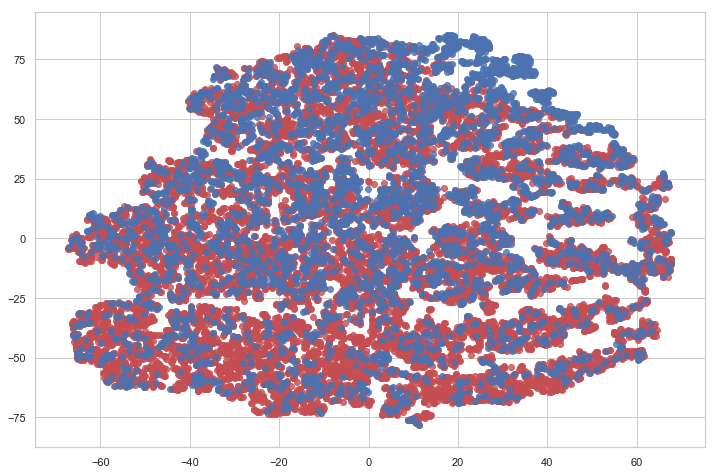

In [137]:
plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], 
            marker='o', color='r', linewidth='1', alpha=0.8, label='Non Fraud')

plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], 
            marker='o', color='b', linewidth='1', alpha=0.8, label='Non Fraud')



We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package.

In [144]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [145]:
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               6000      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_24 (Dense)             (None, 59)                5959      
Total params: 24,659
Trainable params: 24,659
Non-trainable params: 0
_________________________________________________________________


In [146]:
autoencoder.compile(optimizer="adadelta", loss="mse")

In [147]:
x = df_final.drop(["is_promoted"], axis=1)
y = df_final["is_promoted"].values

#x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_ano = x[y == 0], x[y == 1]

In [148]:
#x_fraud.shape
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 30, 
                shuffle = True, validation_split = 0.10);

Train on 12000 samples, validate on 3000 samples
Epoch 1/30
12000/12000 [==============================] - 1s 47us/step - loss: 81.9383 - val_loss: 76.0736
Epoch 2/30
12000/12000 [==============================] - 0s 12us/step - loss: 74.3669 - val_loss: 73.6037
Epoch 3/30
12000/12000 [==============================] - 0s 12us/step - loss: 73.1420 - val_loss: 73.1389
Epoch 4/30
12000/12000 [==============================] - 0s 13us/step - loss: 72.8309 - val_loss: 72.9185
Epoch 5/30
12000/12000 [==============================] - 0s 13us/step - loss: 72.5511 - val_loss: 72.5239
Epoch 6/30
12000/12000 [==============================] - 0s 14us/step - loss: 72.2899 - val_loss: 72.4671
Epoch 7/30
12000/12000 [==============================] - 0s 13us/step - loss: 72.1204 - val_loss: 72.2052
Epoch 8/30
12000/12000 [==============================] - 0s 13us/step - loss: 60.1438 - val_loss: 43.9284
Epoch 9/30
12000/12000 [==============================] - 0s 13us/step - loss: 33.8119 - val_lo

#### Obtain the Latent Representations
Now, the model is trained. We are intereseted in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

In [132]:
#Defining the Intermediate Layer Model
hidden_representation  = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('dense_9').output)

In [133]:
norm_hid_rep = hidden_representation.predict(x_norm[:15000])
fraud_hid_rep = hidden_representation.predict(x_ano)

In [134]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [135]:
rep_x = tsne.fit_transform(rep_x)

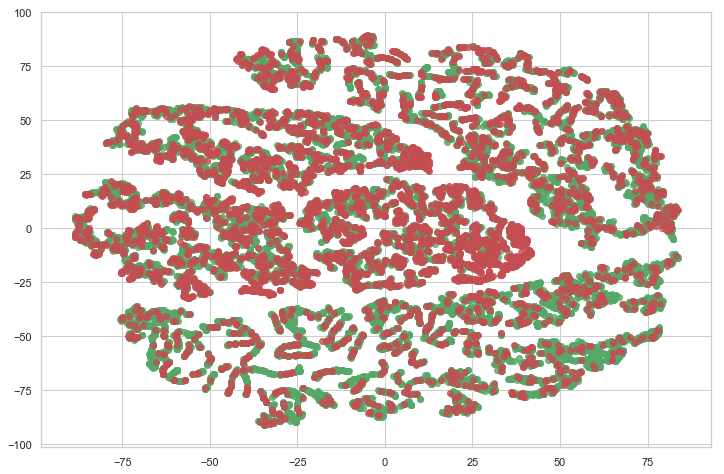

In [136]:
plt.figure(figsize=(12, 8))
plt.scatter(rep_x[np.where(rep_y == 0), 0], rep_x[np.where(rep_y == 0), 1], 
            marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')

plt.scatter(rep_x[np.where(rep_y == 1), 0], rep_x[np.where(rep_y == 1), 1], 
            marker='o', color='r', linewidth='1', alpha=0.8, label='Non Fraud')

